# Draft 1 - Figure 1

__Brainstormed Description:__  

_Maps Regional (IPCC) and Spatial (5x5deg) of a. Naive ToE, b. Strict ToE, and c. Delay (Strict minus Naive)_

So I will need to work with both the IPCC regional and 5x5 degree spatial data. This will be similar to figure 4 as well.

### Load functions and packages

In [1]:
import glob
import os

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import regionmask

import cartopy.crs as ccrs

import copy

%matplotlib inline

In [2]:
def sp_map(*nrs, projection = ccrs.PlateCarree(), **kwargs):
    return plt.subplots(*nrs, subplot_kw={'projection':projection}, **kwargs)


def to_png(file, filename, loc='/glade/u/home/jonahshaw/figures/',dpi=200,ext='png',**kwargs):
    '''
    Simple function for one-line saving.
    Saves to "/glade/u/home/jonahshaw/figures" by default
    '''
    output_dir = loc
    #ext = 'png'
    full_path = '%s%s.%s' % (output_dir,filename,ext)

    if not os.path.exists(output_dir + filename):
        file.savefig(full_path,format=ext, dpi=dpi,**kwargs)
#         file.clf()
        
    else:
        print('File already exists, rename or delete.')

In [3]:
def convert_ipcc_to_latlon(
    data: xr.DataArray,
    mask: regionmask.Regions = regionmask.defined_regions.ar6.all,
):

    mean_data   = data.sel(metric='mean')
    strict_data = data.sel(metric='strict')
    delay_data  = data.sel(metric='delay')
    delay_mask  = data.sel(metric='delay_mask')

    # ipcc_ar6_regions_land   = regionmask.defined_regions.ar6.land
    # ipcc_ar6_regions_all    = regionmask.defined_regions.ar6.all

    # unc_mask = ipcc_ar6_regions_land.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)
    unc_mask = mask.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)

    # CESM1-GISTEMP 5x5
    _mean_mask   = unc_mask.copy()
    _strict_mask = unc_mask.copy()
    _delay_data_mask  = unc_mask.copy()
    _delay_mask_mask  = unc_mask.copy()

    del unc_mask

    offset = -1000 # Need an offset or it may confuse regions with the delays (delays are on [0,40] similar to the region indices)
    for i in mask.numbers:
        
        _mean_mask   = xr.where(_mean_mask==i,mean_data.sel(RegionIndex=i)+offset,_mean_mask)
        _strict_mask = xr.where(_strict_mask==i,strict_data.sel(RegionIndex=i)+offset,_strict_mask)
        _delay_data_mask  = xr.where(_delay_data_mask==i,delay_data.sel(RegionIndex=i)+offset,_delay_data_mask)
        _delay_mask_mask  = xr.where(_delay_mask_mask==i,delay_mask.sel(RegionIndex=i)+offset,_delay_mask_mask)

    regional_masked_da = xr.concat([_mean_mask,_strict_mask,_delay_data_mask,_delay_mask_mask],dim='metric')-offset
    
    return regional_masked_da

## Load compute ToE data

In [4]:
toe_savedir = "/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/ToE_output"

spatial_masked_da = xr.open_dataarray(f"{toe_savedir}/ToE_delay.5x5.nc")
regional_masked_da = xr.open_dataarray(f"{toe_savedir}/ToE_delay.IPCCRegions.nc")

## Spatial (5x5 deg.) Data

### Load processed trend data

#### Models

In [3]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/xagg'
mpi_dir         = 'MPI-GE/xagg'
canesm2_dir     = 'CanESM2/xagg'
esm2m_dir       = 'ESM2M/xagg'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

Take percentiles from PI-Control Runs of models

In [4]:
cesm1_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,cesm1_dir))
mpi_spatial_trends_filepath     = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,mpi_dir))
canesm2_spatial_trends_filepath = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_spatial_trends_filepath   = glob.glob('%s/%s/*5x5degSpatialTrends.3_120_years.Percentiles.nc' % (pic_tseries_dir,esm2m_dir))

In [5]:
cesm1_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_regional_trends_filepath     = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_regional_trends_filepath = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [6]:
cesm1_pic_spatial_trends_all   = xr.open_dataarray(*cesm1_spatial_trends_filepath)

mpi_pic_spatial_trends_all     = xr.open_dataarray(*mpi_spatial_trends_filepath)

canesm2_pic_spatial_trends_all = xr.open_dataarray(*canesm2_spatial_trends_filepath)

esm2m_pic_spatial_trends_all   = xr.open_dataarray(*esm2m_spatial_trends_filepath)

In [7]:
cesm1_pic_regional_trends_all   = xr.open_dataarray(*cesm1_regional_trends_filepath).chunk({"RegionIndex": 1})
cesm1_pic_regional_trends_all["percentile"] = cesm1_pic_regional_trends_all["percentile"] * 100

mpi_pic_regional_trends_all     = xr.open_dataarray(*mpi_regional_trends_filepath).chunk({"RegionIndex": 1})
mpi_pic_regional_trends_all["percentile"] = mpi_pic_regional_trends_all["percentile"] * 100

canesm2_pic_regional_trends_all = xr.open_dataarray(*canesm2_regional_trends_filepath).chunk({"RegionIndex": 1})
canesm2_pic_regional_trends_all["percentile"] = canesm2_pic_regional_trends_all["percentile"] * 100

esm2m_pic_regional_trends_all   = xr.open_dataarray(*esm2m_regional_trends_filepath).chunk({"RegionIndex": 1})
esm2m_pic_regional_trends_all["percentile"] = esm2m_pic_regional_trends_all["percentile"] * 100

#### Observations

And the OBS-LE is effectively used as a model so I just want the percentiles.

In [8]:
obs_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/'
gistemp_5x5_dir = 'GISTEMP_5x5/20240820/xagg/'
hadcrut5_dir = 'HadCRUT5/20240820/xagg/'
dcent_unfilled_dir = 'DCENT/20240901/xagg/'
obsle_dir       = 'mckinnon_OLENS/'

In [9]:
gistemp_tas_var = 'tas'
hadcrut5_tas_var = 'tas'
dcent_unfilled_tas_var = "temperature"
obsle_tas_var    = 'tas'

In [13]:
gistemp_5x5_spatial_trends_filepath = '%s/%s/ensembleChunks_0001_0200.trends.movingstartdate.5x5.190001-202012.nc' % (obs_tseries_dir, gistemp_5x5_dir)
hadcrut5_spatial_trends_filepath = '%s/%s/HadCRUT.5.0.2.0.001_200.trends.movingstartdate.5x5.190001-202212.nc' % (obs_tseries_dir, hadcrut5_dir)
dcent_unfilled_spatial_trends_filepath = '%s/%s/DCENT_ensemble_1850_2023.001_200.trends.movingstartdate.5x5.190001-202312.nc' % (obs_tseries_dir, dcent_unfilled_dir)
# obsle_spatial_trends_filepath        = glob.glob('%s/%s/*.5x5*1921_1922.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

In [14]:
gistemp_5x5_regional_trends_filepath = '%s/%s/ensembleChunks_0001_0200.trends.movingstartdate.IPCCRegions.190001-202012.nc' % (obs_tseries_dir,gistemp_5x5_dir)
hadcrut5_regional_trends_filepath = '%s/%s/HadCRUT.5.0.2.0.001_200.trends.movingstartdate.IPCCRegions.190001-202212.nc' % (obs_tseries_dir,hadcrut5_dir)
dcent_unfilled_regional_trends_filepath = "%s/%s/DCENT_ensemble_1850_2023.001_200.trends.movingstartdate.IPCCRegions.190001-202312.nc" % (obs_tseries_dir,dcent_unfilled_dir)
# obsle_regional_trends_filepath        = glob.glob('%s/%s/*region*1921_1925.Percentiles*.nc' % (obs_tseries_dir,obsle_dir))

Load computed start years

In [15]:
gistemp_5x5_spatial_startyears_filepath = '%s/%s/ensembleChunks_0001_0200.startyears.5x5.190001-202012.nc' % (obs_tseries_dir, gistemp_5x5_dir)
hadcrut5_spatial_startyears_filepath = '%s/%s/HadCRUT.5.0.2.0.0001_0200.startyears.5x5.190001-202412.nc' % (obs_tseries_dir, hadcrut5_dir)
dcent_unfilled_spatial_startyears_filepath = '%s/%s/DCENT_ensemble_1850_2023.001_200.startyears.5x5.190001-202312.nc' % (obs_tseries_dir, dcent_unfilled_dir)

In [16]:
gistemp_5x5_regional_startyears_filepath = '%s/%s/ensembleChunks_0001_0200.startyears.IPCCRegions.190001-202012.nc' % (obs_tseries_dir, gistemp_5x5_dir)
hadcrut5_regional_startyears_filepath = '%s/%s/HadCRUT.5.0.2.0.001_0200.startyears.IPCCRegions.190001-202412.nc' % (obs_tseries_dir, hadcrut5_dir)
dcent_unfilled_regional_startyears_filepath = "%s/%s/DCENT_ensemble_1850_2023.001_200.startyears.IPCCRegions.190001-202312.nc" % (obs_tseries_dir, dcent_unfilled_dir)

Load the trend data

In [17]:
gistemp_5x5_spatial_trends_all = xr.open_dataset(gistemp_5x5_spatial_trends_filepath)["TAS_trends"].drop_vars(['startyear', "quantile"]).squeeze()
hadcrut5_spatial_trends_all = xr.open_dataset(hadcrut5_spatial_trends_filepath)["TAS_trends"].drop_vars(['startyear', "quantile"]).squeeze().sortby("realization")
dcent_unfilled_spatial_trends_all = xr.open_dataset(dcent_unfilled_spatial_trends_filepath)["TAS_trends"].drop_vars(['startyear', "quantile"]).squeeze().sortby("realization")
# obsle_spatial_trends_all        = xr.open_dataarray(*obsle_spatial_trends_filepath).compute()

In [18]:
gistemp_regional_trends_all = xr.open_dataarray(gistemp_5x5_regional_trends_filepath).sel(startyear=1).drop_vars(['startyear', "quantile"]).chunk({"RegionIndex": 1})
hadcrut5_regional_trends_all = xr.open_dataarray(hadcrut5_regional_trends_filepath).sel(startyear=1).drop_vars(['startyear', "quantile"]).squeeze().sortby("realization").chunk({"RegionIndex": 1})
dcent_unfilled_regional_trends_all = xr.open_dataarray(dcent_unfilled_regional_trends_filepath).sel(startyear=1).drop_vars(['startyear', "quantile"]).squeeze().sortby("realization").chunk({"RegionIndex": 1})
# obsle_regional_trends_all        = xr.open_dataarray(*obsle_regional_trends_filepath)

Load the start year data

In [19]:
gistemp_5x5_spatial_startyears = xr.open_dataset(gistemp_5x5_spatial_startyears_filepath)["year"]
hadcrut5_spatial_startyears = xr.open_dataset(hadcrut5_spatial_startyears_filepath).sortby("realization")["year"]
dcent_unfilled_spatial_startyears = xr.open_dataset(dcent_unfilled_spatial_startyears_filepath).sortby("realization")["year"]

In [20]:
gistemp_regional_startyears = xr.open_dataarray(gistemp_5x5_regional_startyears_filepath)
hadcrut5_regional_startyears = xr.open_dataarray(hadcrut5_regional_startyears_filepath).sortby("realization")
dcent_unfilled_regional_startyears = xr.open_dataarray(dcent_unfilled_regional_startyears_filepath).sortby("realization")

Convert the start years across multiple realizations to the single year used for each data production (see preprocess3.5_obsIPCC_identifystartdate.ipynb)

In [21]:
def process_startyears(
    startyears: xr.DataArray,
    earliest_startyear: int,
    fillvalue: int,
    ens_dim: str = "realization",
):

    startyears_mid = startyears.quantile(0.5, dim=ens_dim)
    
    # Set values less than earliest_startyear to earliest_startyear.
    startyears_final = xr.where(
        startyears_mid > earliest_startyear,
        startyears_mid, 
        earliest_startyear,
    )
    # Revert masking to a nan
    startyears_final = startyears_final.where(startyears_final != fillvalue)
    
    return startyears_final
    

In [22]:
earliest_startyear = 1900
fillvalue = 2100

gistemp_5x5_spatial_startyears = process_startyears(
    gistemp_5x5_spatial_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()
hadcrut5_spatial_startyears = process_startyears(
    hadcrut5_spatial_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()
dcent_unfilled_spatial_startyears = process_startyears(
    dcent_unfilled_spatial_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()

gistemp_regional_startyears = process_startyears(
    gistemp_regional_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()
hadcrut5_regional_startyears = process_startyears(
    hadcrut5_regional_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()
dcent_unfilled_regional_startyears = process_startyears(
    dcent_unfilled_regional_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()

### Compute TTE generally

In [24]:
obs_spatial_trend_dict  = {
    'GISTEMP_5x5': gistemp_5x5_spatial_trends_all,
    'HadCRUT': hadcrut5_spatial_trends_all,
    "DCENT_unfilled": dcent_unfilled_spatial_trends_all,
}
obs_regional_trend_dict = {
    'GISTEMP_5x5': gistemp_regional_trends_all,
    'HadCRUT': hadcrut5_regional_trends_all,
    "DCENT_unfilled": dcent_unfilled_regional_trends_all,
}
obs_trend_dict = {
    'spatial':obs_spatial_trend_dict,
    'regional':obs_regional_trend_dict,
}

obs_spatial_startyear_dict  = {
    'GISTEMP_5x5': gistemp_5x5_spatial_startyears,
    'HadCRUT': hadcrut5_spatial_startyears,
    "DCENT_unfilled": dcent_unfilled_spatial_startyears
}
obs_regional_startyear_dict = {
    'GISTEMP_5x5': gistemp_regional_startyears,
    'HadCRUT': hadcrut5_regional_startyears,
    "DCENT_unfilled": dcent_unfilled_regional_startyears,
}
obs_startyear_dict = {
    'spatial':obs_spatial_startyear_dict,
    'regional':obs_regional_startyear_dict,
}

model_spatial_trend_dict = {'CESM1':cesm1_pic_spatial_trends_all,
                            'MPI':mpi_pic_spatial_trends_all,
                            'CanESM2':canesm2_pic_spatial_trends_all,
                            'ESM2M':esm2m_pic_spatial_trends_all,
                            # 'OBS-LE':obsle_spatial_trends_all,
                           }

model_regional_trend_dict = {'CESM1':cesm1_pic_regional_trends_all,
                             'MPI':mpi_pic_regional_trends_all,
                             'CanESM2':canesm2_pic_regional_trends_all,
                             'ESM2M':esm2m_pic_regional_trends_all,
                            #  'OBS-LE':obsle_regional_trends_all,
                            }
                                         
model_trend_dict          = {'spatial':model_spatial_trend_dict,
                             'regional':model_regional_trend_dict}

Compute the TTE for each ensemble member separately.

In [25]:
def compute_tte(
    obs_trends,
    pic_trends,
    startyears,
):
    '''
    General function comparing the observed trends with the PIC trends to determine TTE.
    '''
    # Can only test up to the longest sampled duration of PI-Control or observations
    duration_limit = np.minimum(obs_trends.duration.max(), pic_trends.duration.max())
    
    _tte_bool = obs_trends > pic_trends
    _tte      = _tte_bool.duration.where(~_tte_bool).max(dim='duration')
    _tte      = _tte.where(_tte != duration_limit, np.nan) # Mask the unemerged regions
    _tte      = _tte.drop_vars(['percentile'])
    
    _tte      = _tte + startyears
    
    return _tte

Ok, down to 3 minutes now which isn't terrible.

In [27]:
%%time 

spatial_box = []
regional_box = []

# Iterate over regional vs. spatial
for _location_type in list(obs_trend_dict.keys()):
    
    print(_location_type)
    _box = spatial_box if (_location_type == 'spatial') else regional_box
    location_box = []
    
    _allobs_trends = obs_trend_dict[_location_type]
    _allobs_startyears = obs_startyear_dict[_location_type]
    _allmodel_trends = model_trend_dict[_location_type]
    
    for _obs_product in list(_allobs_trends.keys()):
        print(_obs_product)
        obs_box = []
        
        _obs_trends = _allobs_trends[_obs_product]
        _obs_startyears = _allobs_startyears[_obs_product]
        
        for _model_product in list(_allmodel_trends.keys()):
            print(_model_product)
            _model_trends = _allmodel_trends[_model_product]
            
            # Compute ToE of the median trend (more consistent with using the 50%ile trend for mean)
            _mean_toe = compute_tte(
                obs_trends=_obs_trends.median(dim='realization'),
                pic_trends=_model_trends.sel(percentile=97.5),
                startyears=_obs_startyears,
            )

            # Compute ToE for each ensemble member and take the 95th percentile
            _strict_toe = compute_tte(
                obs_trends=_obs_trends,
                pic_trends=_model_trends.sel(percentile=97.5),
                startyears=_obs_startyears,
            )

            # Switch nans to infs in order to compute the strict ToE correctly. Then switch infs back to nans in order to mask correctly.
            _strict_toe = _strict_toe.where(~np.isnan(_strict_toe),np.inf).quantile(q=0.95, dim='realization', method='nearest')
            _strict_toe = _strict_toe.where(~np.isinf(_strict_toe),np.nan)
            
            # Compute the delay and conditional delay mask:
            _delay_toe = _strict_toe - _mean_toe # Compute the delay
            _delay_undef_region = np.bitwise_and(np.isnan(_strict_toe), ~np.isnan(_mean_toe)) # Mask for where tas is emerged in the mean but not the "strict" sense.
            _delay_toe = xr.where(_delay_undef_region, 2020 - _mean_toe, _delay_toe) # Apply the conditional mask
            
            _toes = xr.concat([_mean_toe.assign_coords({'metric':'mean'},).expand_dims(['metric'],axis=[-1]),
                               _strict_toe.assign_coords({'metric':'strict'},).expand_dims(['metric'],axis=[-1]),
                               _delay_toe.assign_coords({'metric':'delay'},).expand_dims(['metric'],axis=[-1]),
                               _delay_undef_region.assign_coords({'metric':'delay_mask'},).expand_dims(['metric'],axis=[-1]),
                              ],
                              dim='metric',
                             )            
                              
            obs_box.append(_toes.assign_coords({'model':_model_product},).expand_dims(['model'],axis=[-1]))
                        
        location_box.append(xr.concat(obs_box,dim='model').assign_coords({'obs':_obs_product},).expand_dims(['obs'],axis=[-1]))
    _box.append(xr.concat(location_box, dim='obs').compute())
    
spatial_masked_da = spatial_box[0]
regional_masked_da = regional_box[0]

spatial
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M
HadCRUT
CESM1
MPI
CanESM2
ESM2M
DCENT_unfilled
CESM1
MPI
CanESM2
ESM2M
regional
GISTEMP_5x5
CESM1
MPI
CanESM2
ESM2M
HadCRUT
CESM1
MPI
CanESM2
ESM2M
DCENT_unfilled
CESM1
MPI
CanESM2
ESM2M


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


CPU times: user 56.2 s, sys: 29min 52s, total: 30min 48s
Wall time: 31min 10s


In [31]:
spatial_masked_da.name = "ToE"
regional_masked_da.name = "ToE"

In [32]:
toe_savedir = "/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/ToE_output"

spatial_masked_da.to_netcdf(f"{toe_savedir}/ToE_delay.5x5.nc")
regional_masked_da.to_netcdf(f"{toe_savedir}/ToE_delay.IPCCRegions.nc")

# Plot with IPCC Regions

Need to convert the IPCC Region Indexing to lat-lon coordinates in order to plot spatially.

In [ ]:
# Apply the land mask here.
regional_latlon_da = convert_ipcc_to_latlon(
    regional_masked_da,
    mask=regionmask.Regions=regionmask.defined_regions.ar6.land,
)

Mask like the DCENT data so the visual comparison is much easier.

In [12]:
# Mask before converting to lat-lon
regional_maskedlikeDCENT_da = regional_masked_da.where(~np.isnan(regional_masked_da.sel(obs="DCENT_unfilled")))
# Convert to lat-lon
regional_latlonlikeDCENT_da = convert_ipcc_to_latlon(regional_maskedlikeDCENT_da)

In [15]:
# Mask the spatial ToE data with DCENT availability
spatial_maskedlikeDCENT_da = spatial_masked_da.where(~np.isnan(spatial_masked_da.sel(obs="DCENT_unfilled")))

In [6]:
# Function for the regional figures.
def plot_regional_toe_and_delay(
    data,
    obs,
    model,
    toe_levels=np.linspace(1960,2020,13),
    delay_levels=list(np.linspace(0,20,5)),
    title=True,
):
    
    data_subset     = data.sel(obs=obs,model=model)
    data_mean       = data_subset.sel(metric='mean')
    data_strict     = data_subset.sel(metric='strict')
    data_delay      = data_subset.sel(metric='delay')
    data_delay_mask = data_subset.sel(metric='delay_mask')

    fig,axs = sp_map(1,3,projection=ccrs.Robinson(),figsize=(14,4))
    axs = axs.flat

    cax1 = plt.axes([0.18, 0.22, 0.40, 0.03])
    cax2 = plt.axes([0.675, 0.22, 0.20, 0.03])

    ToE_cmap = copy.copy(mpl.cm.viridis)
    ToE_cmap.set_over('white')
    
    delay_cmap = sns.light_palette('red',n_colors=10,reverse=False,as_cmap=True)
    delay_cmap.set_over('magenta')
    # delay_levels = list(np.linspace(0,20,5))
    
    masks  = [data_mean,data_strict,data_delay]
    titles = ['Mean ToE','Strict ToE','Observational delay']
    levels = [toe_levels,toe_levels,delay_levels]
    cmaps  = [ToE_cmap,ToE_cmap,delay_cmap]
    extend = ['max','max','max']

    plt.subplots_adjust(wspace=0.05)

    ims = [] 
    for _ax,_mask,_label,_levels,_cmap,_extend in zip(axs,masks,titles,levels,cmaps,extend):

        im = _ax.contourf(_mask.lon,_mask.lat,_mask, 60,
                          transform=ccrs.PlateCarree(),
                          levels=_levels,
                          cmap=_cmap,
                          extend=_extend,
                         )

        _ax.coastlines()
        _ax.set_global()
        _ax.set_title(_label,fontsize=16)

        ims.append(im)

    _ = axs[2].contourf(data_delay_mask.lon,data_delay_mask.lat,data_delay_mask, levels=[0,0.5,2], colors='none',
                        transform=ccrs.PlateCarree(),
                        hatches=[None,'\\\\',],
                        extend='max',
                       )

    grey = axs[2].contourf(data_delay.lon,data_delay.lat,np.isnan(data_delay),
                           transform=ccrs.PlateCarree(),
                           extend='max',colors=['none','gray'],levels=[0,0.5,1.5],
                          )

    cbar1 = fig.colorbar(ims[0],orientation='horizontal',
                         ticks=toe_levels,
                         cax=cax1,
                        )

    cbar2 = fig.colorbar(ims[2],orientation='horizontal',
                         ticks=delay_levels, 
                         cax=cax2,
                        )

    cbar1.ax.tick_params(labelsize=12) 
    cbar2.ax.tick_params(labelsize=12)
    
    if title:
        fig.suptitle('IPCC Region Emergence: %s-%s' % (model,obs),fontsize=20,y=0.88)
    
    return fig

It works.

In [7]:
out_fig = plot_regional_toe_and_delay(
    regional_latlon_da,
    obs='GISTEMP_5x5',
    model='CESM1',
    toe_levels=np.linspace(1900, 2020, 13),
    delay_levels=np.linspace(0, 25, 6),
)

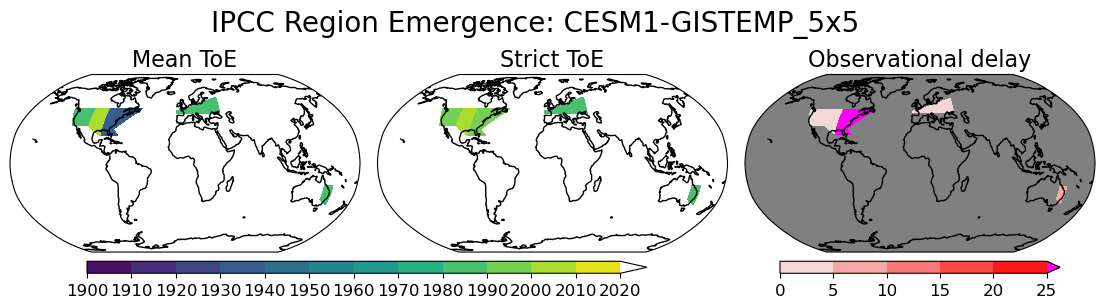

In [14]:
out_fig = plot_regional_toe_and_delay(
    regional_latlonlikeDCENT_da,
    obs='GISTEMP_5x5',
    model='CESM1',
    toe_levels=np.linspace(1900, 2020, 13),
    delay_levels=np.linspace(0, 25, 6),
)

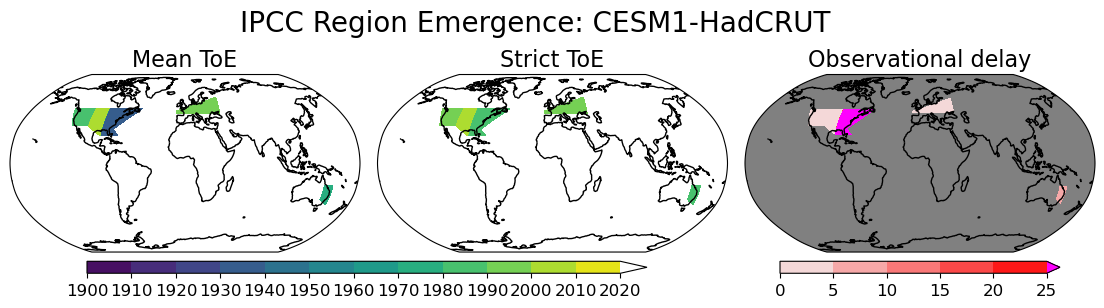

In [22]:
out_fig = plot_regional_toe_and_delay(
    regional_latlonlikeDCENT_da,
    obs='HadCRUT',
    model='CESM1',
    toe_levels=np.linspace(1900, 2020, 13),
    delay_levels=np.linspace(0, 25, 6),
)

In [8]:
out_fig = plot_regional_toe_and_delay(
    regional_latlon_da,
    obs='DCENT_unfilled',
    model='CESM1',
    toe_levels=np.linspace(1900, 2020, 13),
    delay_levels=np.linspace(0, 25, 6),
)

In [ ]:
out_fig = plot_regional_toe_and_delay(
    regional_masked_da,
    obs='DCENT_unfilled',
    model='CESM1',
    toe_levels=np.linspace(1900, 2020, 13),
    delay_levels=np.linspace(0, 25, 6),
)

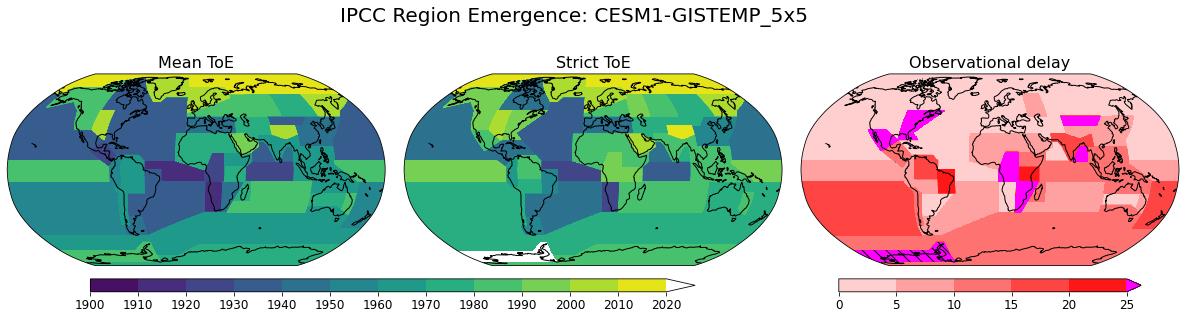

In [ ]:
out_fig = plot_regional_toe_and_delay(
    regional_masked_da,
    obs='GISTEMP_5x5',
    model='CESM1',
    toe_levels=np.linspace(1900, 2020, 13),
    delay_levels=np.linspace(0, 25, 6),
)

Create a bunch of figures.

CPU times: user 23.6 s, sys: 23.7 ms, total: 23.6 s
Wall time: 25.6 s


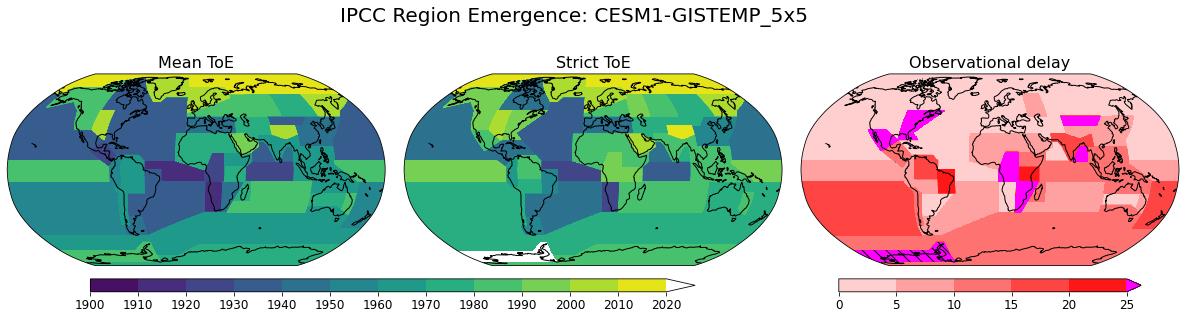

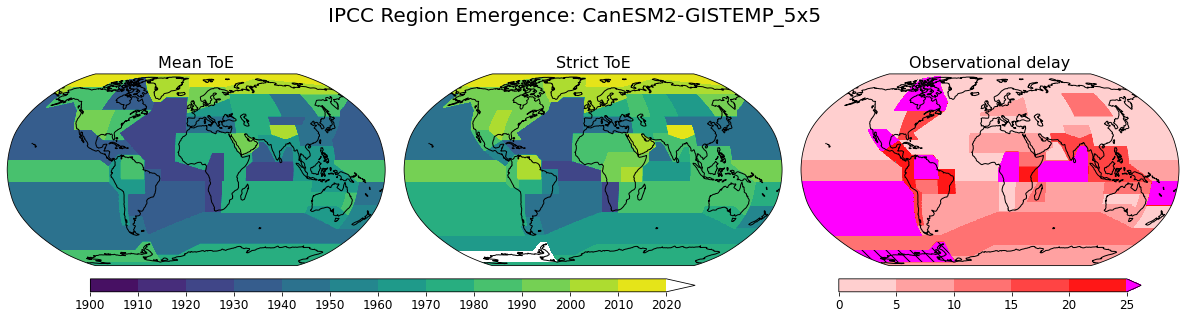

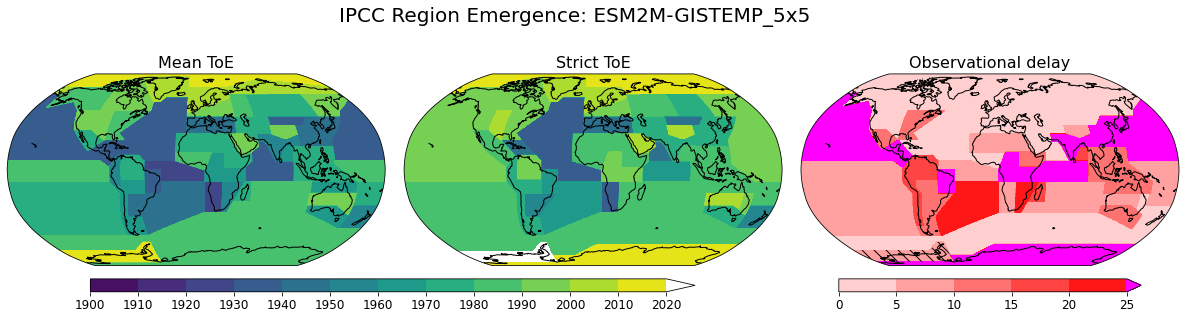

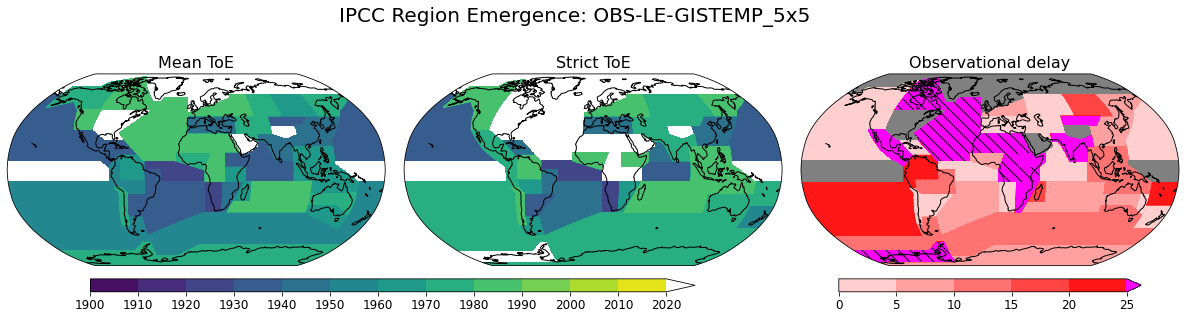

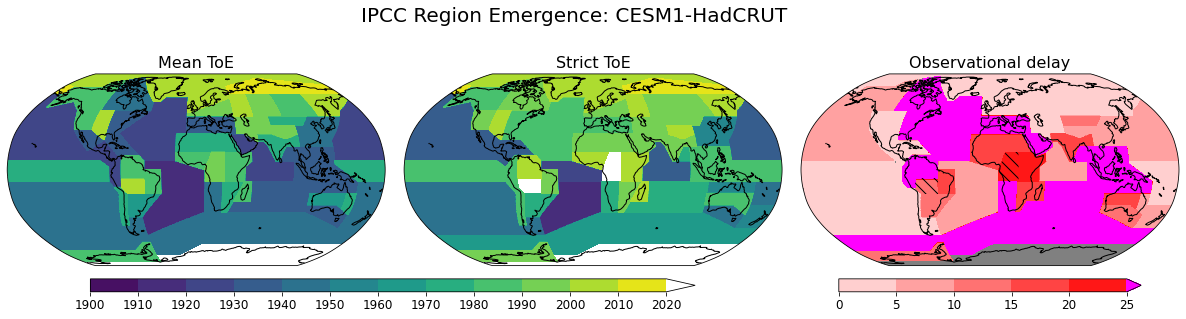

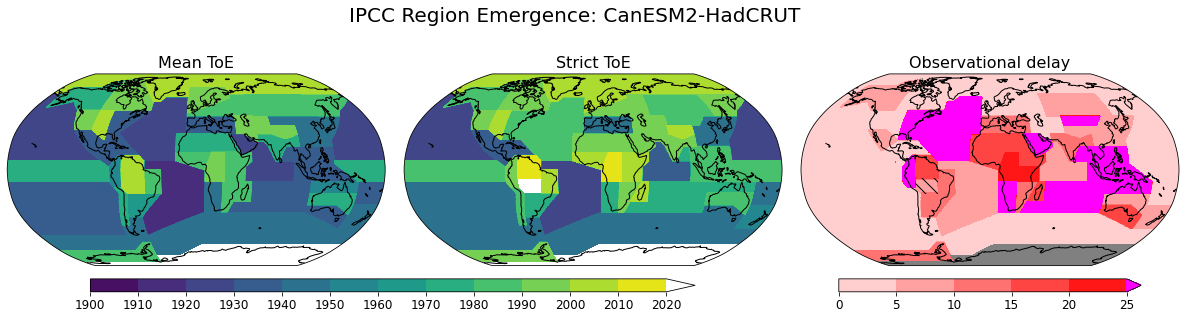

In [226]:
%%time

for _obs in regional_masked_da.obs:
        
    for _model in regional_masked_da.model:
        
        out_fig = plot_regional_toe_and_delay(
            regional_masked_da,
            obs=_obs.values,
            model=_model.values,
            toe_levels=np.linspace(1900, 2020, 13),
            delay_levels=np.linspace(0, 25, 6),
        )
        
        # to_png(file=out_fig,filename='draft2_ToE_regionalmap_1900start_%s_%s' % (_obs.values,_model.values),dpi=300,ext='png',bbox_inches='tight')

Agreement on the west coast of S. America, Australia, and Antarctica, Southern Ocean.

### Plot with Spatial Data

In [ ]:
landmask = regionmask.defined_regions.natural_earth_v5_1_2.land_50

In [16]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

In [17]:
def plot_spatial_toe_and_delay(
    data,
    obs,
    model,
    toe_levels=np.linspace(1960,2020,13),
    delay_levels=list(np.linspace(0,20,5)),
    title=True,
):

    data_subset = data.sel(obs=obs,model=model)
    mean_data   = data_subset.sel(metric='mean')
    strict_data = data_subset.sel(metric='strict')
    delay_data  = data_subset.sel(metric='delay')
    delay_mask  = data_subset.sel(metric='delay_mask')

    fig,axs = sp_map(1,3,projection=ccrs.Robinson(),figsize=(14, 4))
    axs = axs.flat

    cax1 = plt.axes([0.175, 0.22, 0.40, 0.03])
    cax2 = plt.axes([0.685, 0.22, 0.20, 0.03])

    ToE_cmap = copy.copy(mpl.cm.viridis)
    ToE_cmap.set_over('white')
    
    delay_cmap = sns.light_palette('red',n_colors=10,reverse=False,as_cmap=True)
    delay_cmap.set_over('magenta')
    delay_cmap.colorbar_extend = True

    masks  = [mean_data,strict_data,delay_data]
    titles = ['Mean ToE','Strict ToE','Observational delay']
    levels = [toe_levels,toe_levels,delay_levels] 
    cmaps = [ToE_cmap,ToE_cmap,delay_cmap]

    plt.subplots_adjust(wspace=0.05)
    
    ims = [] 
    for _ax,_mask,_label,_levels,_cmap in zip(axs,masks,titles,levels,cmaps):

        _norm = BoundaryNorm(_levels, ncolors=_cmap.N, clip=False)

        im = _ax.pcolormesh(_mask.lon,_mask.lat,_mask,
                           transform=ccrs.PlateCarree(),
                           cmap=_cmap,
                           norm=_norm, 
                           )

        _ax.coastlines()
        _ax.set_global()
        _ax.set_title(_label,fontsize=16)

        ims.append(im)

    _ = axs[2].contourf(delay_mask.lon,delay_mask.lat,delay_mask, levels=[0,0.5,2], colors='none',
                        transform=ccrs.PlateCarree(),
                        hatches=[None,'\\\\',],
                        extend='max',
                       )

    grey = axs[2].contourf(mean_data.lon,mean_data.lat,np.isnan(mean_data),
                           transform=ccrs.PlateCarree(),
                           extend='max',colors=['none','gray'],levels=[0,0.5,1.5],
                          )
        
    cbar1 = fig.colorbar(ims[0],orientation='horizontal',
                         ticks=toe_levels,
                         cax=cax1,
                         extend='max',
                        )

    cbar2 = fig.colorbar(ims[2],orientation='horizontal',
                         ticks=delay_levels, # delay_levels, 
                         cax=cax2,
                         extend='max',
                        )

    cbar1.ax.tick_params(labelsize=12) 
    cbar2.ax.tick_params(labelsize=12)

    if title:
        fig.suptitle('5x5 Emergence: %s-%s' % (model,obs),fontsize=20,y=0.88)    

    return fig

In [18]:
# User set-up
data  = spatial_masked_da
obs = 'DCENT_unfilled' # HadCRUT
model = 'CESM1'

out = plot_spatial_toe_and_delay(
    data=data,
    obs=obs,
    model=model,
    toe_levels=np.linspace(1900, 2020, 13),
    delay_levels=np.linspace(0, 25, 6),
)

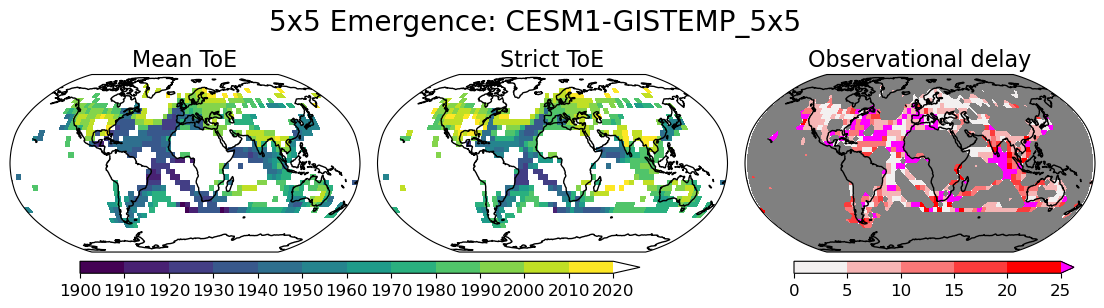

In [20]:
# User set-up
data  = spatial_maskedlikeDCENT_da
obs = 'GISTEMP_5x5' # HadCRUT
model = 'CESM1'

out = plot_spatial_toe_and_delay(
    data=data,
    obs=obs,
    model=model,
    toe_levels=np.linspace(1900, 2020, 13),
    delay_levels=np.linspace(0, 25, 6),
)

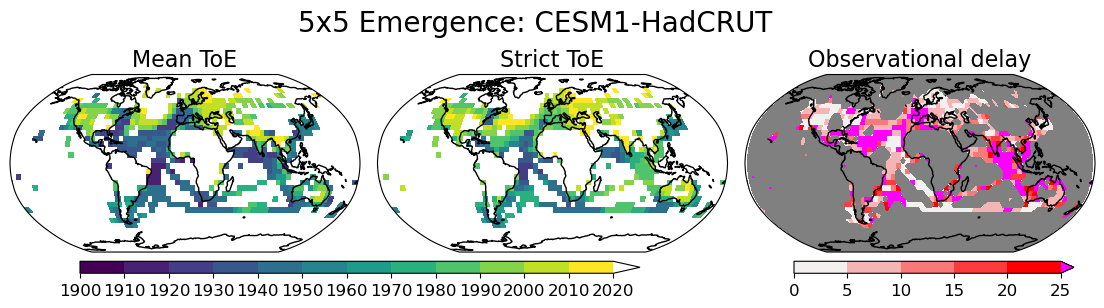

In [21]:
# User set-up
data  = spatial_maskedlikeDCENT_da
obs = 'HadCRUT' # HadCRUT
model = 'CESM1'

out = plot_spatial_toe_and_delay(
    data=data,
    obs=obs,
    model=model,
    toe_levels=np.linspace(1900, 2020, 13),
    delay_levels=np.linspace(0, 25, 6),
)

In [ ]:
# User set-up
data  = spatial_masked_da
obs = 'GISTEMP_5x5' # HadCRUT
model = 'CESM1'

out = plot_spatial_toe_and_delay(
    data=data,
    obs=obs,
    model=model,
    toe_levels=np.linspace(1900, 2020, 13),
    delay_levels=np.linspace(0, 25, 6),
)

In [ ]:
# User set-up
data  = spatial_masked_da
obs = 'GISTEMP_5x5' # HadCRUT
model = 'CESM1'

out = plot_spatial_toe_and_delay(
    data=data,
    obs=obs,
    model=model,
    toe_levels=np.linspace(1900, 2020, 13),
    delay_levels=np.linspace(0, 25, 6),
)

Woah what is going on in the equatorial Atlantic? It emerges after 20 years.

CPU times: user 2.42 s, sys: 11.4 ms, total: 2.43 s
Wall time: 2.5 s


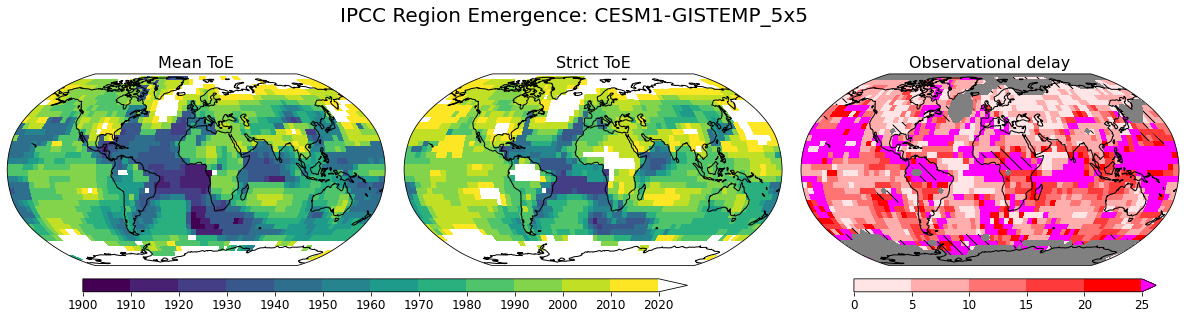

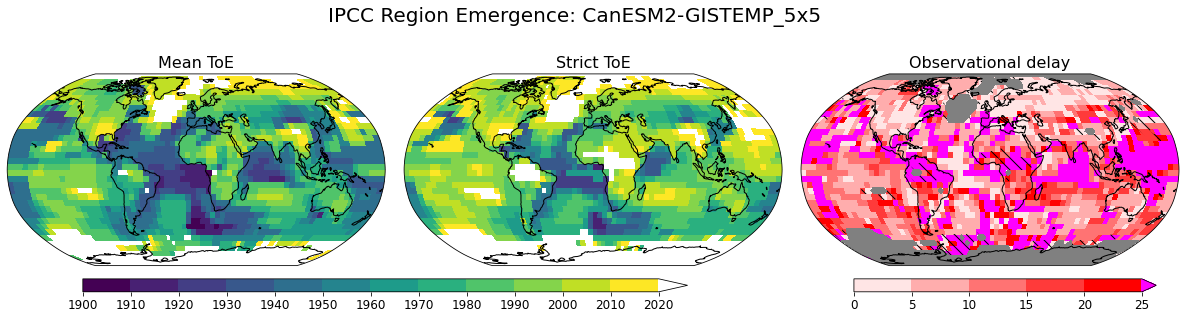

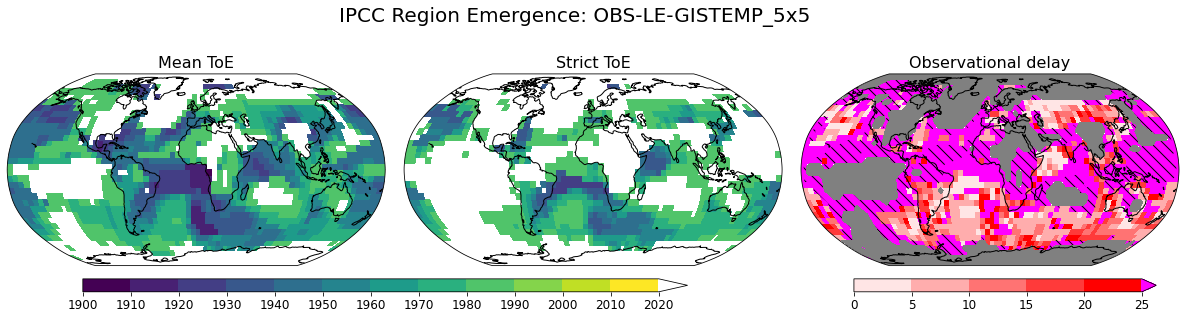

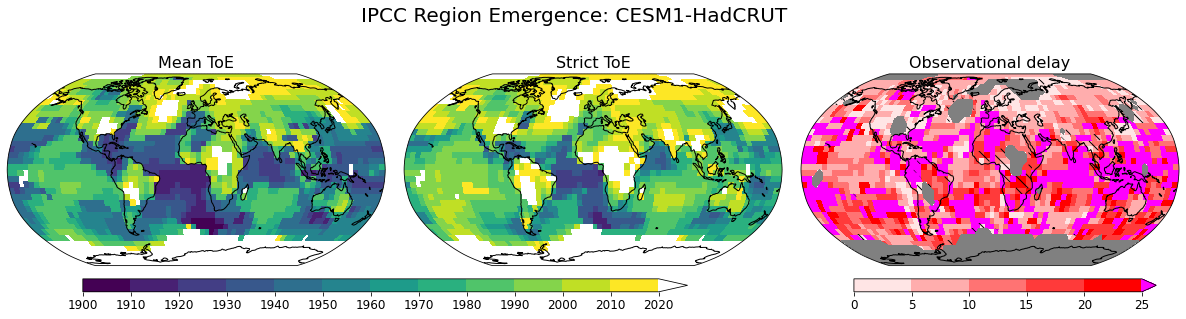

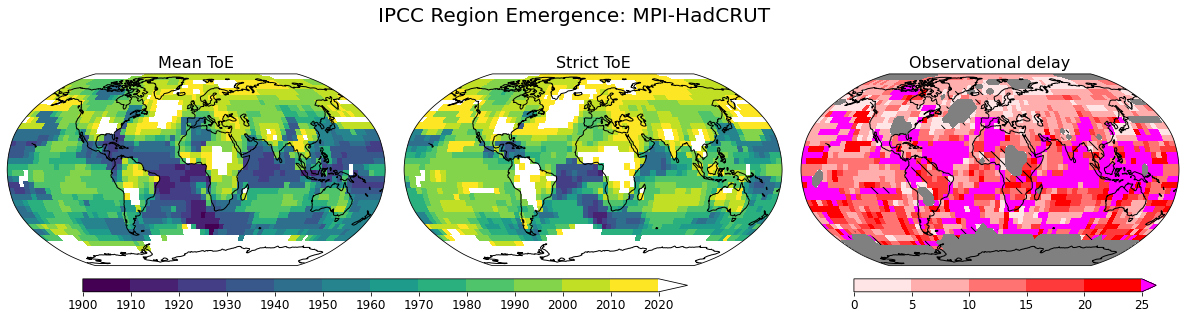

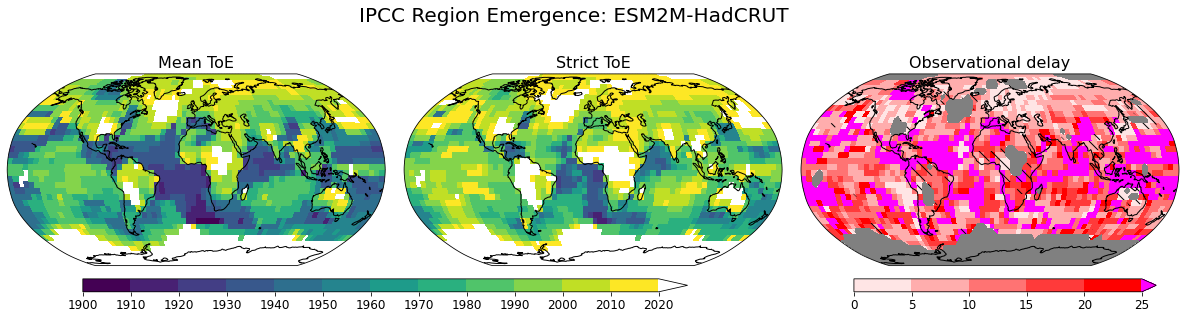

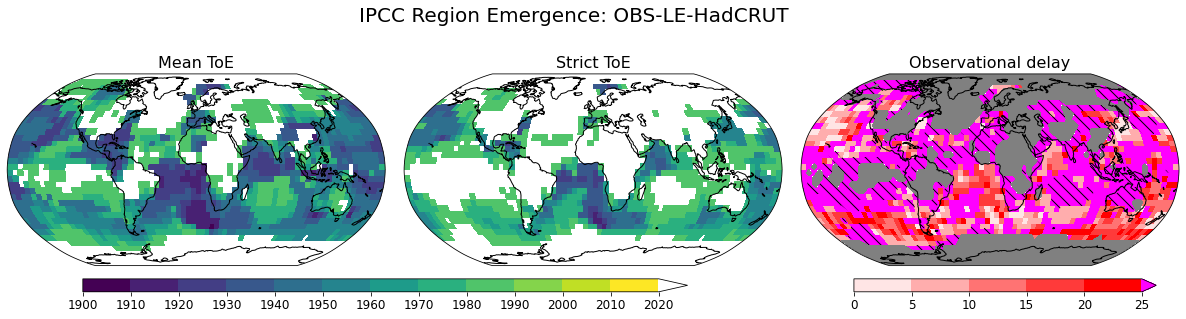

In [230]:
%%time

for _obs in regional_masked_da.obs:
        
    for _model in regional_masked_da.model:
        
        out_fig = plot_spatial_toe_and_delay(
            spatial_masked_da,
            obs=_obs.values,
            model=_model.values,
            toe_levels=np.linspace(1900, 2020, 13),
            delay_levels=np.linspace(0, 25, 6),
        )
        
        # to_png(file=out_fig,filename='draft2_ToE_spatialmap_1900start_%s_%s' % (_obs.values,_model.values),dpi=300,ext='png',bbox_inches='tight')        

This is confusing to me. The regional delays are small in HadCRUT, but the spatial delays are large. So this seems to imply that there is low spatial correlation in the data, such that averaging effectively removes the observational noise and the delay.